<a href="https://colab.research.google.com/github/lobnaabdelhamed97/German-traffic-sign-classification/blob/master/trafficclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#step1:Download the dataset
from google.colab import files
files.upload()  #upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lobnaabdelhamed","key":"1c9bcaa0517f9be89a195f8ad7139a97"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [4]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100% 609M/612M [00:03<00:00, 139MB/s]
100% 612M/612M [00:03<00:00, 184MB/s]


In [5]:
!mkdir trafficsign
!unzip gtsrb-german-traffic-sign -d trafficsign


Archive:  gtsrb-german-traffic-sign.zip
  inflating: trafficsign/Meta.csv    
  inflating: trafficsign/Meta/.~lock.ClassesInformation.ods#  
  inflating: trafficsign/Meta/.~lock.ClassesInformationStrong.ods#  
  inflating: trafficsign/Meta/0.png  
  inflating: trafficsign/Meta/1.png  
  inflating: trafficsign/Meta/10.png  
  inflating: trafficsign/Meta/11.png  
  inflating: trafficsign/Meta/12.png  
  inflating: trafficsign/Meta/13.png  
  inflating: trafficsign/Meta/14.png  
  inflating: trafficsign/Meta/15.png  
  inflating: trafficsign/Meta/16.png  
  inflating: trafficsign/Meta/17.png  
  inflating: trafficsign/Meta/18.png  
  inflating: trafficsign/Meta/19.png  
  inflating: trafficsign/Meta/2.png  
  inflating: trafficsign/Meta/20.png  
  inflating: trafficsign/Meta/21.png  
  inflating: trafficsign/Meta/22.png  
  inflating: trafficsign/Meta/23.png  
  inflating: trafficsign/Meta/24.png  
  inflating: trafficsign/Meta/25.png  
  inflating: trafficsign/Meta/26.png  
  inflating: 

In [6]:
import os
import time as time

import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from PIL import Image
import time
from datetime import timedelta
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import skimage.morphology as morp
from skimage.filters import rank

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout # new!
from keras.layers.normalization import BatchNormalization # new!
from keras import regularizers # new! 
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D # new!
from keras.callbacks import ModelCheckpoint

import cv2


Using TensorFlow backend.


   Width  Height  Roi.X1  ...  Roi.Y2  ClassId                            Path
0     27      26       5  ...      20       20  Train/20/00020_00000_00000.png
1     28      27       5  ...      22       20  Train/20/00020_00000_00001.png
2     29      26       6  ...      21       20  Train/20/00020_00000_00002.png
3     28      27       5  ...      22       20  Train/20/00020_00000_00003.png
4     28      26       5  ...      21       20  Train/20/00020_00000_00004.png

[5 rows x 8 columns]


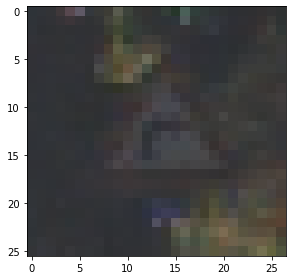

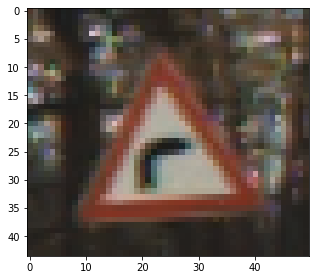

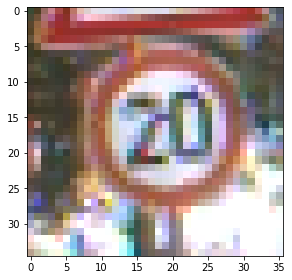

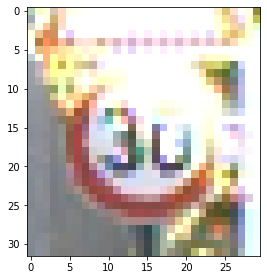

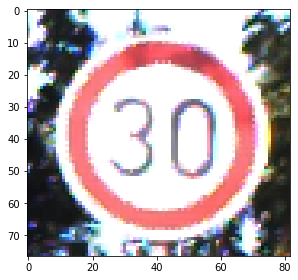

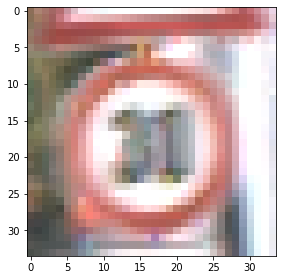

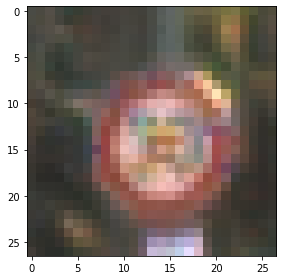

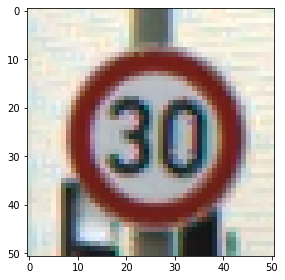

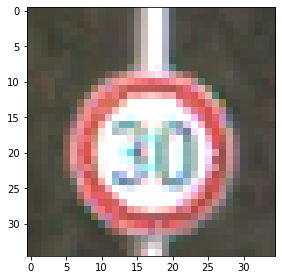

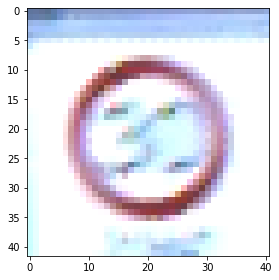

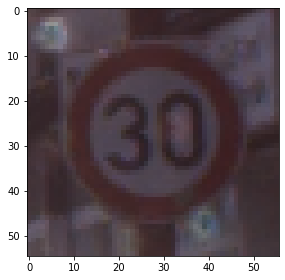

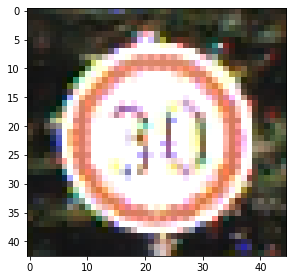

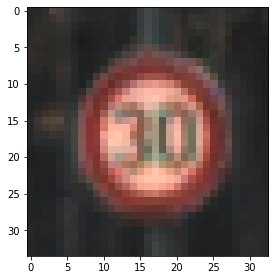

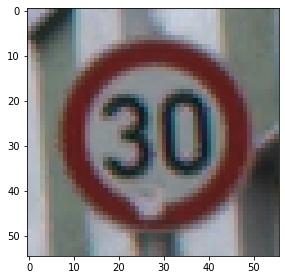

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


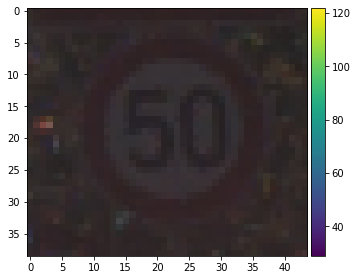

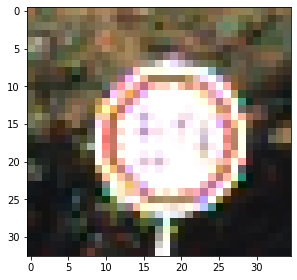

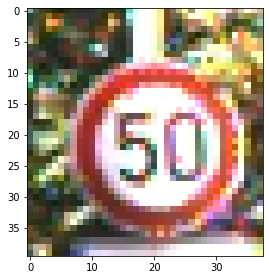

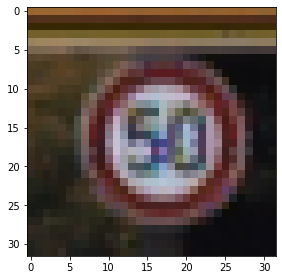

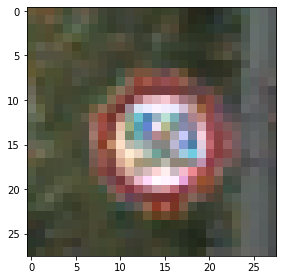

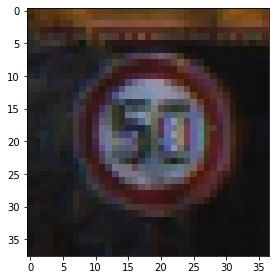

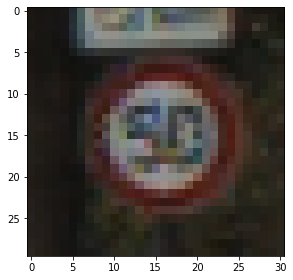

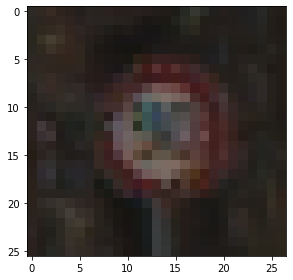

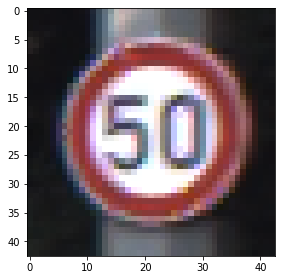

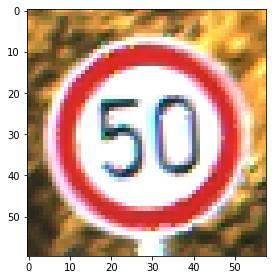

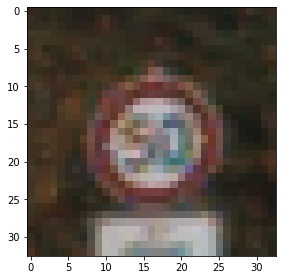

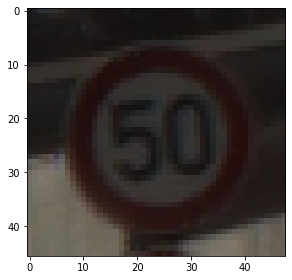

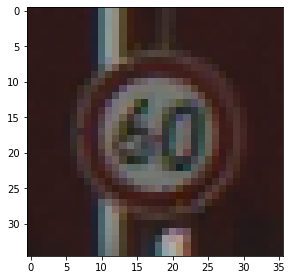

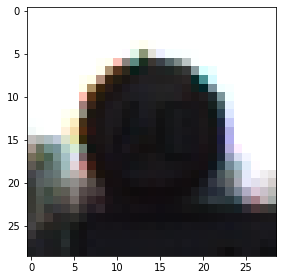

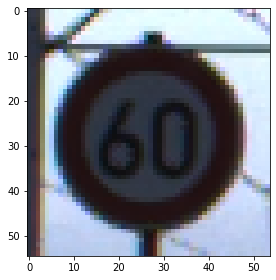

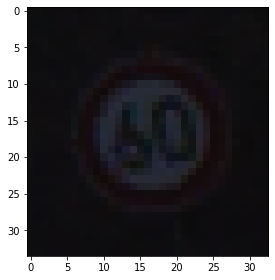

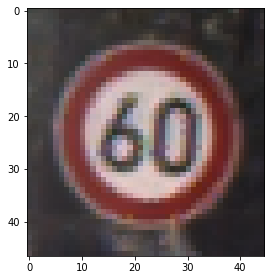

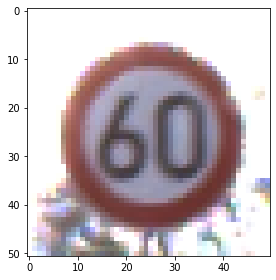

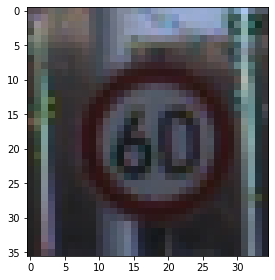

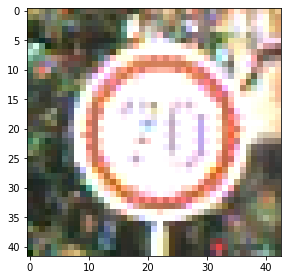

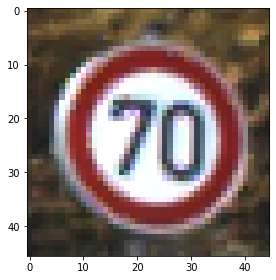

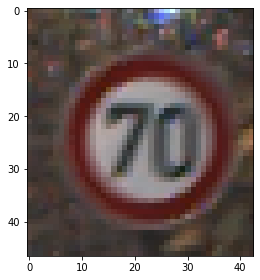

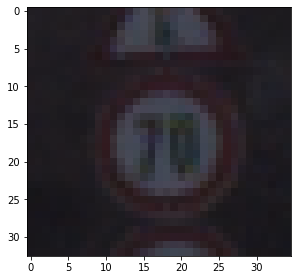

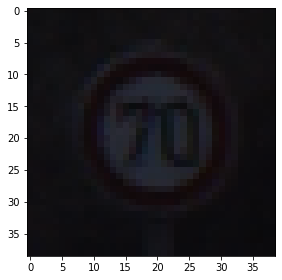

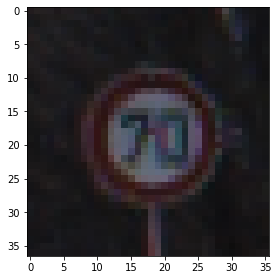

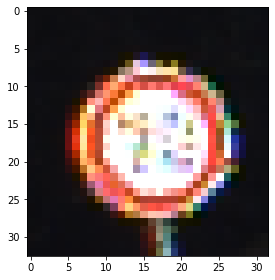

In [13]:
import pandas as pd 
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
a='/content/trafficsign/Train.csv'

trafficDataset = pd.read_csv(a,encoding='latin1') 
print(trafficDataset.head())
trainpath = trafficDataset.Path
a='/content/trafficsign/'
for counter in range (0,40):
 
  image = imread(a+trainpath[counter*200])

  imshow(image)
  plt.show()
  


In [0]:
import pandas as pd 
a='/content/trafficsign/Train.csv'

trafficDataset = pd.read_csv(a,encoding='latin1') 
trainpath = trafficDataset["Path"] 
traininglabel=trafficDataset["ClassId"]
from skimage.io import imread, imshow
training=list()
a='/content/trafficsign/'
for counter in range (0,39209):
  image = imread(a+trainpath[counter])
  resizedimg = np.resize(image, (32,32,3))
  training.append(resizedimg)
  

In [15]:
Cells=np.array(training)
labels=np.array(traininglabel)
(X_train,X_valid)=Cells[(int)(0.11249*len(labels)):],Cells[:(int)(0.11249*len(labels))]
X_train = X_train.astype('float32')/255 
X_valid = X_valid.astype('float32')/255
(y_train,y_valid)=labels[(int)(0.11249*len(labels)):],labels[:(int)(0.11249*len(labels))]
print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))


34799
4410
34799
4410


In [0]:
import pandas as pd 
a='/content/trafficsign/Test.csv'

testDataset = pd.read_csv(a,encoding='latin1') 
testpath = testDataset["Path"] 
testlabel=testDataset["ClassId"]
from skimage.io import imread, imshow
test=list()
a='/content/trafficsign/'
for counter in range (0,12630):
  image = imread(a+testpath[counter])
  resizedimg = np.resize(image, (32,32,3))
  test.append(resizedimg)

In [17]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(test)

# The shape of an traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(43, activation='softmax'))

# **Dense Network Architecture**

In [20]:
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)              

In [0]:
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_valid_baseline = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, 43)
y_valid_baseline = keras.utils.to_categorical(y_valid, 43)

In [25]:
model.fit(X_train_baseline, y_train_baseline, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid_baseline, y_valid_baseline))




Train on 34799 samples, validate on 4410 samples
Epoch 1/100





34799/34799 [==============================] - 5s 141us/step - loss: 0.0228 - acc: 0.0676 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 2/100
34799/34799 [==============================] - 3s 92us/step - loss: 0.0219 - acc: 0.1258 - val_loss: 0.0244 - val_acc: 0.0000e+00
Epoch 3/100
34799/34799 [==============================] - 3s 91us/step - loss: 0.0216 - acc: 0.1527 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 4/100
34799/34799 [==============================] - 3s 92us/step - loss: 0.0213 - acc: 0.1664 - val_loss: 0.0246 - val_acc: 0.0016
Epoch 5/100
34799/34799 [==============================] - 3s 95us/step - loss: 0.0211 - acc: 0.1783 - val_loss: 0.0247 - val_acc: 4.5351e-04
Epoch 6/100
34799/34799 [==============================] - 3s 94us/step - loss: 0.0209 - acc: 0.1863 - val_loss: 0.0247 - val_acc: 4.5351e-04
Epoch 7/100
34799/34799 [==============================] - 3s 95us/step - loss: 0.0208 - acc: 

In [0]:
test=np.array(test)
testbaseline = test.reshape(len(test), 32*32*3).astype('float32')
testlabelbaseline = keras.utils.to_categorical(testlabel, 43)

In [27]:
prediction = model.evaluate(testbaseline, testlabelbaseline, verbose=0)
print("Dense network ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], prediction[0]))
print("%s- %.2f" % (model.metrics_names[1], prediction[1]))

Dense network 
 
loss- 0.04
acc- 0.11


# Establishing a score without any preprocessing

In [29]:
Pred= model.predict(testbaseline, batch_size=128,verbose=1)
Prediction = np.argmax(Pred, axis=1)
from sklearn.metrics import classification_report,f1_score
classification_report(testlabel, Prediction)



12630/12630 [==============================] - 0s 22us/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'              precision    recall  f1-score   support\n\n           0       0.01      0.23      0.01        60\n           1       0.05      0.13      0.07       720\n           2       0.00      0.00      0.00       750\n           3       0.00      0.00      0.00       450\n           4       0.13      0.17      0.14       660\n           5       0.00      0.00      0.00       630\n           6       0.00      0.00      0.00       150\n           7       0.00      0.00      0.00       450\n           8       0.00      0.00      0.00       450\n           9       0.20      0.18      0.19       480\n          10       0.00      0.00      0.00       660\n          11       0.00      0.00      0.00       420\n          12       0.88      0.06      0.11       690\n          13       0.10      0.70      0.17       720\n          14       0.00      0.00      0.00       270\n          15       0.00      0.00      0.00       210\n          16       0.03      0.03      0.03       150\n       

# Data Preprocessing

In [0]:
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

In [0]:
classes = 43

X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records and class_records!=0:
        ovr_sample = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug


In [156]:
print(len(X_train))
print(len(X_train_final))
print(len(y_train))
print(len(y_train_final))

34799
160000
34799
160000


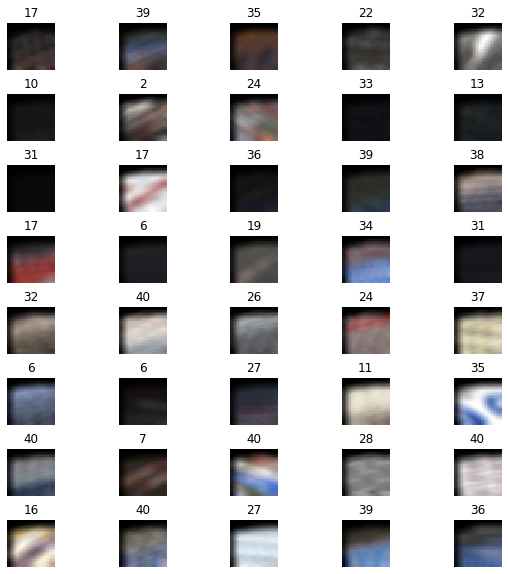

In [158]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])

In [0]:
X_train_aug = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_valid_aug = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, 43)
y_valid_aug = keras.utils.to_categorical(y_valid, 43)
filepath="German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
model.fit(X_train_aug, y_train_aug, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_aug, y_valid_aug))

Train on 160000 samples, validate on 4410 samples
Epoch 1/100
160000/160000 [==============================] - 14s 89us/step - loss: 0.0205 - acc: 0.2247 - val_loss: 0.0268 - val_acc: 0.0290

Epoch 00001: val_acc improved from -inf to 0.02902, saving model to German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5
Epoch 2/100
160000/160000 [==============================] - 14s 89us/step - loss: 0.0198 - acc: 0.2670 - val_loss: 0.0255 - val_acc: 0.0143

Epoch 00002: val_acc did not improve from 0.02902
Epoch 3/100
160000/160000 [==============================] - 14s 90us/step - loss: 0.0195 - acc: 0.2826 - val_loss: 0.0260 - val_acc: 0.0195

Epoch 00003: val_acc did not improve from 0.02902
Epoch 4/100
160000/160000 [==============================] - 14s 90us/step - loss: 0.0193 - acc: 0.2953 - val_loss: 0.0258 - val_acc: 0.0168

Epoch 00004: val_acc did not improve from 0.02902
Epoch 5/100
160000/160000 [==============================] - 15s 91us/step - loss: 0.0191 - acc: 0.3062 - va

In [0]:
X_test_aug = test.reshape(len(test), 32*32*3).astype('float32')
y_test_aug = keras.utils.to_categorical(testlabel, 43)

In [0]:
model.load_weights("German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5")
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [168]:
Pred = model.evaluate(X_test_aug, y_test_aug, verbose=0)
print("Dense fully connected network After Data Augmentation ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - After Data Augmentation 
 
loss- 14.86
acc- 0.07


# greyscale

In [1]:
def gray_scale(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images_data = list(map(gray_scale, X_train_final))

def local_histo_equalize(image):
    
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


local_histo = np.array(list(map(local_histo_equalize, gray_images_data)))
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = np.divide(img,255)
    normalized_images = normalized_images[..., None]
    return normalized_images
X_train_preprocessed = preprocess(X_train_final)
X_valid_preprocessed = preprocess(X_valid)

X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32*32*1).astype('float32')

y_train_final_dn = keras.utils.to_categorical(y_train_final, 43)
y_valid_final_dn = keras.utils.to_categorical(y_valid, 43)

print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)

NameError: ignored

In [0]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*1,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
ilepath="German_Traffic_DenseNetworkModel_final.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(X_train_preprocessed_dn, y_train_final_dn, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_preprocessed_dn, y_valid_final_dn))


In [0]:
X_test_preprocessed = preprocess(test)
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')
y_test_final_dn = keras.utils.to_categorical(testlabel, 43)

In [0]:
model.load_weights("German_Traffic_DenseNetworkModel_final.hdf5")
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
Pred = model.evaluate(X_test_preprocessed_dn, y_test_final_dn, verbose=0)
print("Dense fully connected network results on the test data")
print(" ")
print("%s- %.2f%%" % (model.metrics_names[0], Pred[0]*100))
print("%s- %.2f%%" % (model.metrics_names[1], Pred[1]*100))